### 1. Φόρτωση και Προετοιμασία Δεδομένων
- Καθορίζονται τα paths για τα train/test δεδομένα από το dataset `chest_xray`.
- Χρησιμοποιείται `ImageDataGenerator` για:
  - **Κανονικοποίηση** των pixel values (rescale).
  - **Data augmentation** (μόνο στο training set): περιστροφή, zoom, οριζόντια αναστροφή.
  - **Split**: το 10% των training δεδομένων κρατείται ως validation set.
- Δημιουργούνται οι generators `train_generator`, `val_generator`, `test_generator`.

### 2. Υπολογισμός Class Weights
- Χρησιμοποιείται `compute_class_weight()` για να αντιμετωπιστεί η **ανισορροπία κλάσεων** (Normal vs Pneumonia).
- Δημιουργείται λεξικό `class_weights_dict` που χρησιμοποιείται στην εκπαίδευση.

### 3. Ορισμός Μοντέλου με Hyperparameter Tuning
- Χρησιμοποιείται το εργαλείο
  **Keras Tuner** για αυτόματο πειραματισμό με:
  - Αριθμό φίλτρων στα `Conv2D` layers.
  - Μέγεθος του `Dense` layer.
  - Ποσοστό `Dropout`.
  - Τιμή `learning_rate`.
- Το μοντέλο είναι `Sequential` και καταλήγει σε `sigmoid` για binary classification.

### 4. Εκτέλεση Hyperparameter Search
- Ορίζεται `kt.RandomSearch` με `max_trials=5` για να δοκιμαστούν 5 παραλλαγές του μοντέλου.
- Εκπαίδευση κάθε μοντέλου για 10 εποχές με στόχο την `val_accuracy`.
- Χρησιμοποιείται `EarlyStopping` για να αποφευχθεί overfitting και σπατάλη χρόνου.

### 5. Ανάκτηση Βέλτιστων Υπερπαραμέτρων
- Γίνεται ανάκτηση των καλύτερων υπερπαραμέτρων μέσω `tuner.get_best_hyperparameters()`.
- Εκτυπώνονται οι τιμές για τεκμηρίωση.

### 6. Τελική Εκπαίδευση του Καλύτερου Μοντέλου
- Το καλύτερο μοντέλο (`best_model`) εκπαιδεύεται περαιτέρω για έως 20 εποχές με:
  - `ReduceLROnPlateau`: Μειώνει το learning rate όταν το validation loss σταθεροποιείται.
  - `EarlyStopping`: Σταματά την εκπαίδευση αν δεν υπάρχει βελτίωση, και επαναφέρει τα καλύτερα βάρη (`restore_best_weights=True`).
  - Χρήση `class_weights_dict` για επιπλέον ισορροπία κατά την εκπαίδευση. θα χρειαζόταν για χειροκίνητη ρύθμιση.


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")
import kagglehub
from keras.metrics import AUC
import shutil

## 1. Data preprocessing

#### Original dataset had 5856 images split into train, val, test folders by class (NORMAL, PNEUMONIA).

train/test sets ratio : 80%/10%, 
but validation set was very small (only ~16 images), which is not enough for good evaluation.

Solution:
- Merge all images from train, val, test per class into one list 
- Randomly shuffle this list (with fixed seed)
- Split images into new train/val/test sets with 80% / 10% / 10% ratio.
- Copies images into new folders organized by the new splits and classes.

*Result:* balanced dataset splits with enough images in validation set for reliable model evaluation

In [80]:
import pandas as pd
random.seed(42)

dataset_path= '/Users/theodosiavidalaki/Downloads/chest_xray'
new_dataset_path = '/Users/theodosiavidalaki/Downloads/chest_xraydokimas'
for split in ['train', 'val', 'test']:
   for cls in ['NORMAL', 'PNEUMONIA']:
       os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
   all_files = []
   for split in ['train', 'val', 'test']:
       source_folder = f'{dataset_path}/{split}/{cls}'
       
       files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
       files = sorted(os.listdir(source_folder))
       all_files.extend([(file, source_folder) for file in files])

   
   random.shuffle(all_files)

   train_files = all_files[:int(len(all_files)*0.8)]
   val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
   test_files = all_files[int(len(all_files)*0.9):]

   for file, source_folder in train_files:
       dest = f'{new_dataset_path}/train/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)

   for file, source_folder in val_files:
       dest = f'{new_dataset_path}/val/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)

   for file, source_folder in test_files:
       dest = f'{new_dataset_path}/test/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)  
import pandas as pd

data = []

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_dataset_path, split, cls)
        count = len(os.listdir(folder))
        data.append({'Split': split, 'Class': cls, 'Images': count})

df = pd.DataFrame(data)
print(df) ## ΤΕΛΙΚΟΣ ΧΩΡΙΣΜΟΣ ΜΕΤΑ ΑΠΟ ΕΠΕΞΕΡΓΑΣΙΑ ##

## ΑΡΧΙΚΟΣ ΧΩΡΙΣΜΟΣ ΕΙΚΟΝΩΝ ΣΕ ΣΑΜΠΣΕΤΣ ##
for cls in ['NORMAL', 'PNEUMONIA']:
    for split in ['train', 'val', 'test']:
        folder = f"{dataset_path}/{split}/{cls}"
        print(split, cls, len(os.listdir(folder)))

   Split      Class  Images
0  train     NORMAL    1266
1  train  PNEUMONIA    3418
2    val     NORMAL     158
3    val  PNEUMONIA     427
4   test     NORMAL     159
5   test  PNEUMONIA     428
train NORMAL 1341
val NORMAL 8
test NORMAL 234
train PNEUMONIA 3875
val PNEUMONIA 8
test PNEUMONIA 390


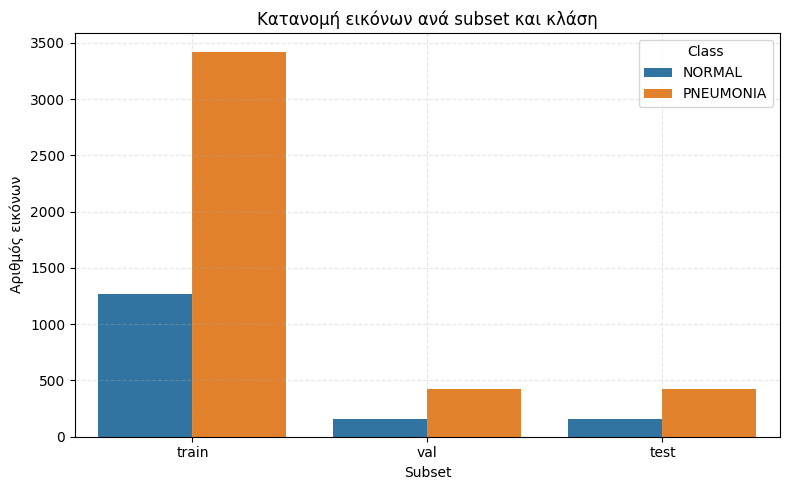

In [81]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Split', y='Images', hue='Class')
plt.title('Κατανομή εικόνων ανά subset και κλάση')
plt.ylabel('Αριθμός εικόνων')
plt.xlabel('Subset')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**The training set has more samples, as it should, and the class ratio remains stable across each subset.**

**However, we do have class imbalance because there are many more samples in the pneumonia class than in the normal class, even though their ratio stays consistent in all subsets.**

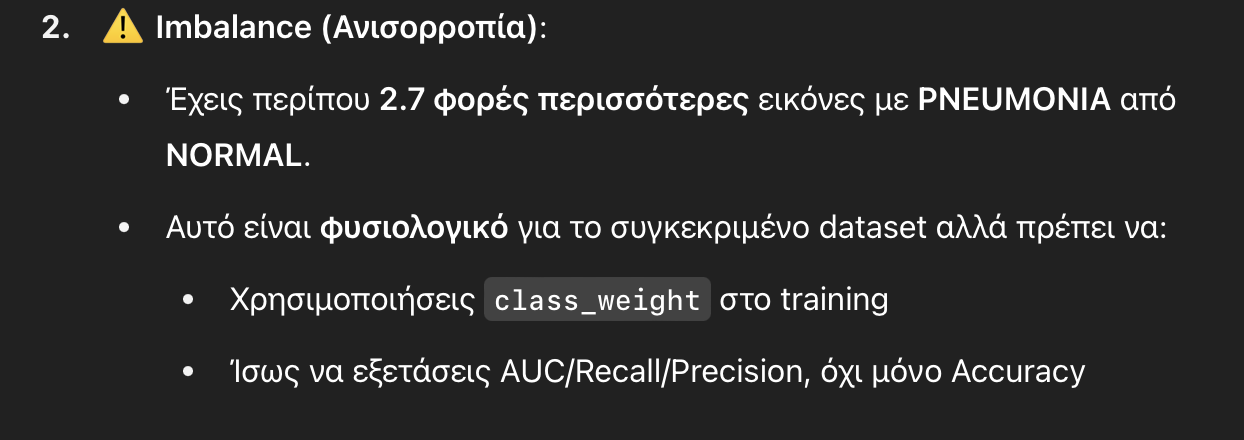

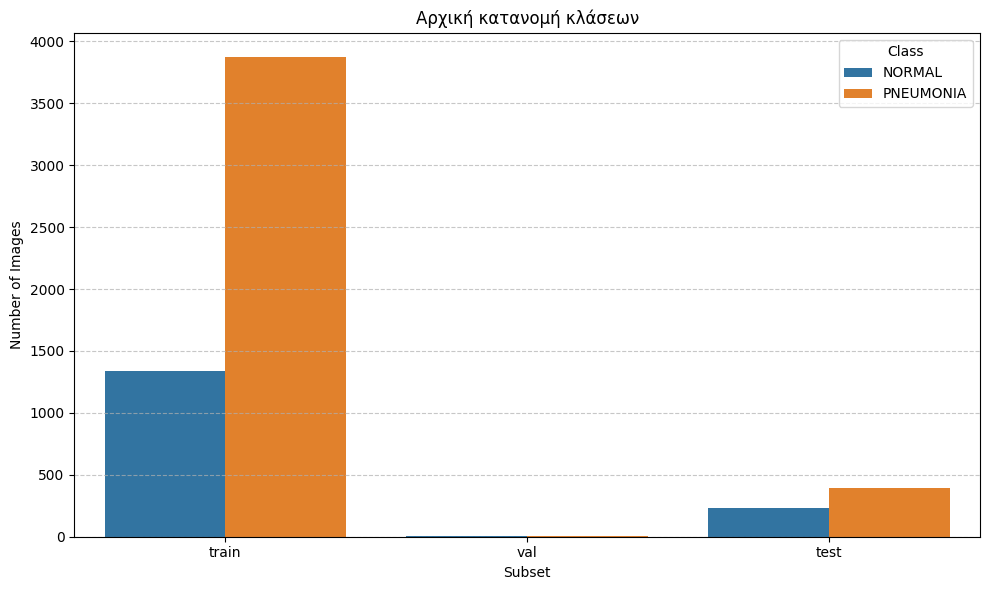

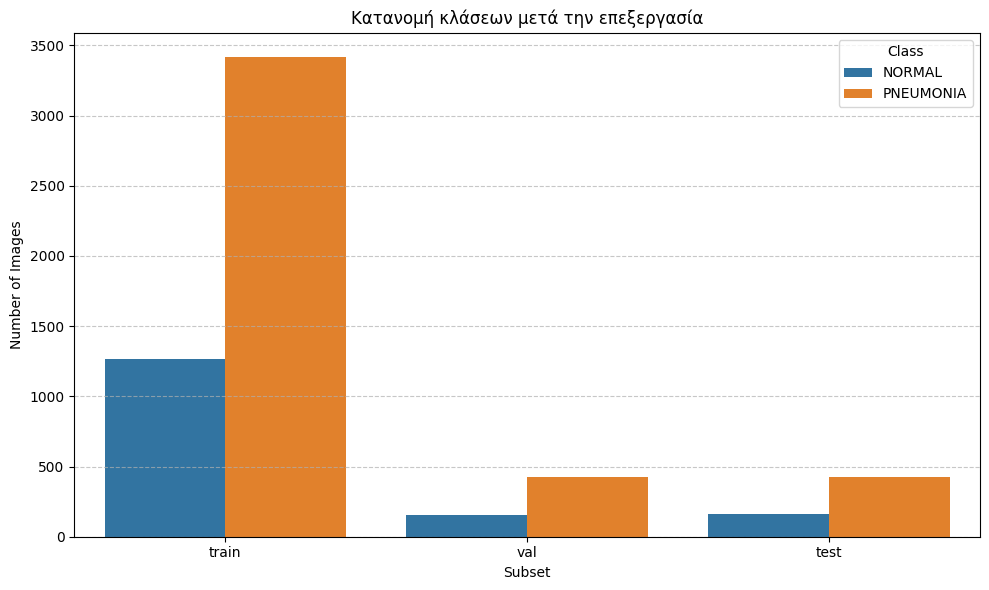

In [82]:
def plot_class_distribution(base_path, title="Κατανομή κλάσεων"):
    data = {'Split': [], 'Class': [], 'Count': []}
    
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            folder = os.path.join(base_path, split, cls)
            count = len(os.listdir(folder))
            data['Split'].append(split)
            data['Class'].append(cls)
            data['Count'].append(count)

    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Split', y='Count', hue='Class', data=df)
    plt.title(title)
    plt.xlabel("Subset")
    plt.ylabel("Number of Images")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#initial distribution
plot_class_distribution('/Users/theodosiavidalaki/Downloads/chest_xray', title="Αρχική κατανομή κλάσεων")

#final distribution
plot_class_distribution('/Users/theodosiavidalaki/Downloads/chest_xraydokimas', title="Κατανομή κλάσεων μετά την επεξεργασία")


--------------------------------------------------------------------------------------------------------------------------------------------------------

### Next step:
- Setting up image data generators for training, validation, and testing using the reorganized dataset
- Data augmentation for training images, rescale pixel values
- Handling class imbalance by computing class weights
- Creation of generators that load images in batches with specified size and labels for binary classification

#### # GIA EMAS 
 It handles imbalance by assigning more importance to the minority class during training. This means the model pays extra attention to the less frequent class to avoid being biased toward the majority class. By doing this, it balances the learning process so that both classes are fairly represented, improving the model’s ability to detect the rarer cases.

In [ ]:
import shutil
import os

if os.path.exists('kt_dir'):
    shutil.rmtree('kt_dir')
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20

base_dir = new_dataset_path
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

#data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

#dealing with the imbalanced classes
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

**Plotting one image from each class (Pneumonia and Normal)**

In [ ]:
# we get a batch from training data
images, labels = next(train_generator)

class_names = {0: "Normal", 1: "Pneumonia"}

# we get only the 1st image of each class
for i in range(len(labels)):
    label = int(labels[i])
    if label == 0:
        normal_img = images[i]
    if label == 1:
        pneumonia_img = images[i]
    if 'normal_img' in locals() and 'pneumonia_img' in locals():
        break

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(normal_img)
plt.title("Normal")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pneumonia_img)
plt.title("Pneumonia")
plt.axis('off')

plt.tight_layout()
plt.show()

## 2. The Model
- A Convolutional Neural Network (CNN) built with the Sequential API
- Contains 3 convolutional layers, each followed by a max-pooling layer
- Includes one fully connected (dense) layer
- Uses dropout for regularization
- Ends with an output dense layer for binary classification
- Compiled with the Adam optimizer, binary cross-entropy loss, and metrics for accuracy and AUC (Area Under the Curve)
- Different values are set for the hyperparameters, as the model will undergo fine-tuning to find the optimal configuration

In [ ]:
#the model
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model

## 3. Hyperparameter Tuning and Training
- Keras Tuner’s Random Search to find the best hyperparameters by maximizing validation AUC.
- Runs up to 8 different trials trying different hyperparameter combinations.
- Trains each trial model on the training data and evaluates on validation data, using class weights to handle imbalance.
- Stops early if no improvement in validation loss for 3 epochs.
- After tuning, selects the best model and its hyperparameters.
- Prints out the best hyperparameter values found.
- Then trains the best model for up to 20 epochs, with learning rate reduction and early stopping to avoid overfitting.

In [85]:
#keras fine-tuning with Randomsearch
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=8,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pneumonia_tuning',
    seed=42
)

#finding the optimal hyperparameters
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

#getting the best model and the best hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

#training the best model
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2), EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)

Trial 8 Complete [00h 04m 01s]
val_auc: 0.9723045825958252

Best val_auc So Far: 0.9821169376373291
Total elapsed time: 00h 32m 39s
Best hyperparameters:
{'conv1_filters': 16, 'conv2_filters': 64, 'conv3_filters': 256, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.00039648863050186525}
Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.9077 - auc: 0.9654 - loss: 0.2524 - val_accuracy: 0.9282 - val_auc: 0.9813 - val_loss: 0.1767 - learning_rate: 3.9649e-04
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.9164 - auc: 0.9708 - loss: 0.2255 - val_accuracy: 0.9419 - val_auc: 0.9788 - val_loss: 0.1616 - learning_rate: 3.9649e-04
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.9273 - auc: 0.9750 - loss: 0.2037 - val_accuracy: 0.9077 - val_auc: 0.9845 - val_loss: 0.2215 - learning_rate: 3.9649e-04
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.9177 - auc: 0.9748 - loss: 0.2141 - val_accuracy: 0.9402 

## 4. Accuracy and Loss over Epochs plots,  to see model's behaviour during training

- Both training and validation results are displayed
- Helps track the model’s learning progress and detect overfitting

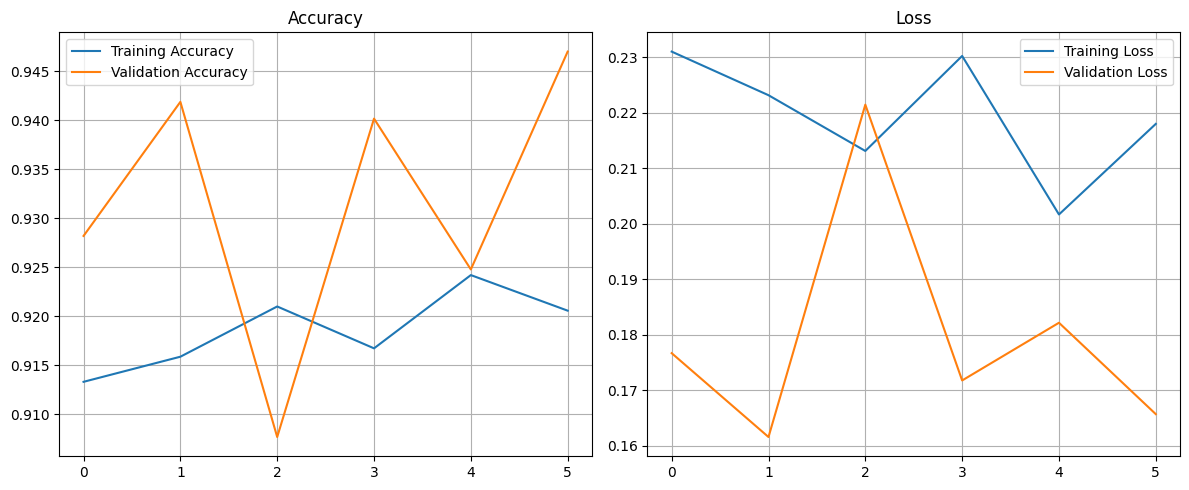

In [94]:
#accuracy and loss plots over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

## 5. Evaluation on the test set 
After that we evaluate the best trained model on the test dataset.

In [ ]:
# evaluation of the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

In [87]:
best_model.save("best_pneumonia_model.keras")

## 6. Model Performance Analysis and Threshold Tuning

In [88]:
from tensorflow.keras.models import load_model
model = load_model("best_pneumonia_model.keras")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step

✅ Best Threshold based on F1 Score: 0.29

Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.90      0.90       159
   Pneumonia       0.96      0.96      0.96       428

    accuracy                           0.95       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.95      0.95      0.95       587



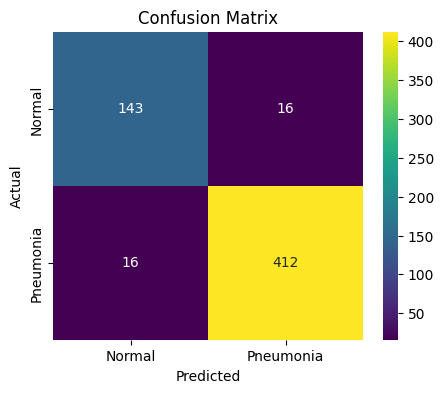

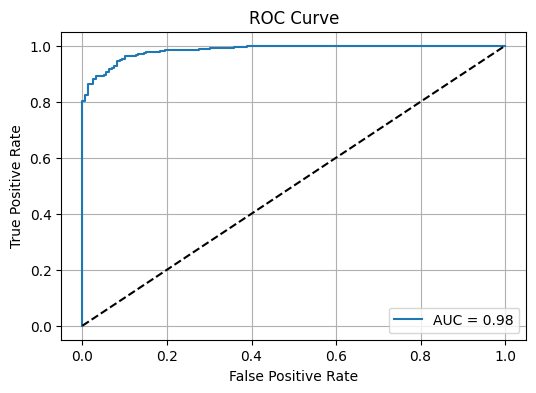

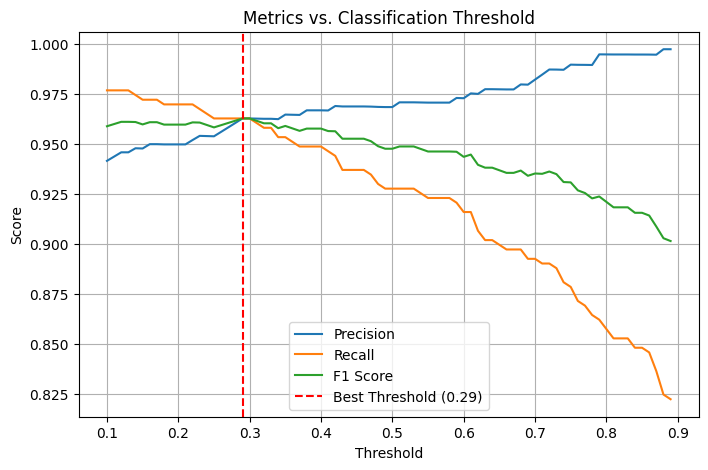

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns

#predict with the best model
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

#calculations of precision, recall, f1 for different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (preds > t).astype(int).reshape(-1)
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))

#finding the threshold that maximizes f1 score
best_index = np.argmax(f1s)
best_threshold = thresholds[best_index]
print(f"\nBest Threshold based on F1 Score: {best_threshold:.2f}")


y_pred = (preds > best_threshold).astype(int).reshape(-1)

#classification report & confusion matrix
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#precision/recall/f1 vs threshold plots
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()


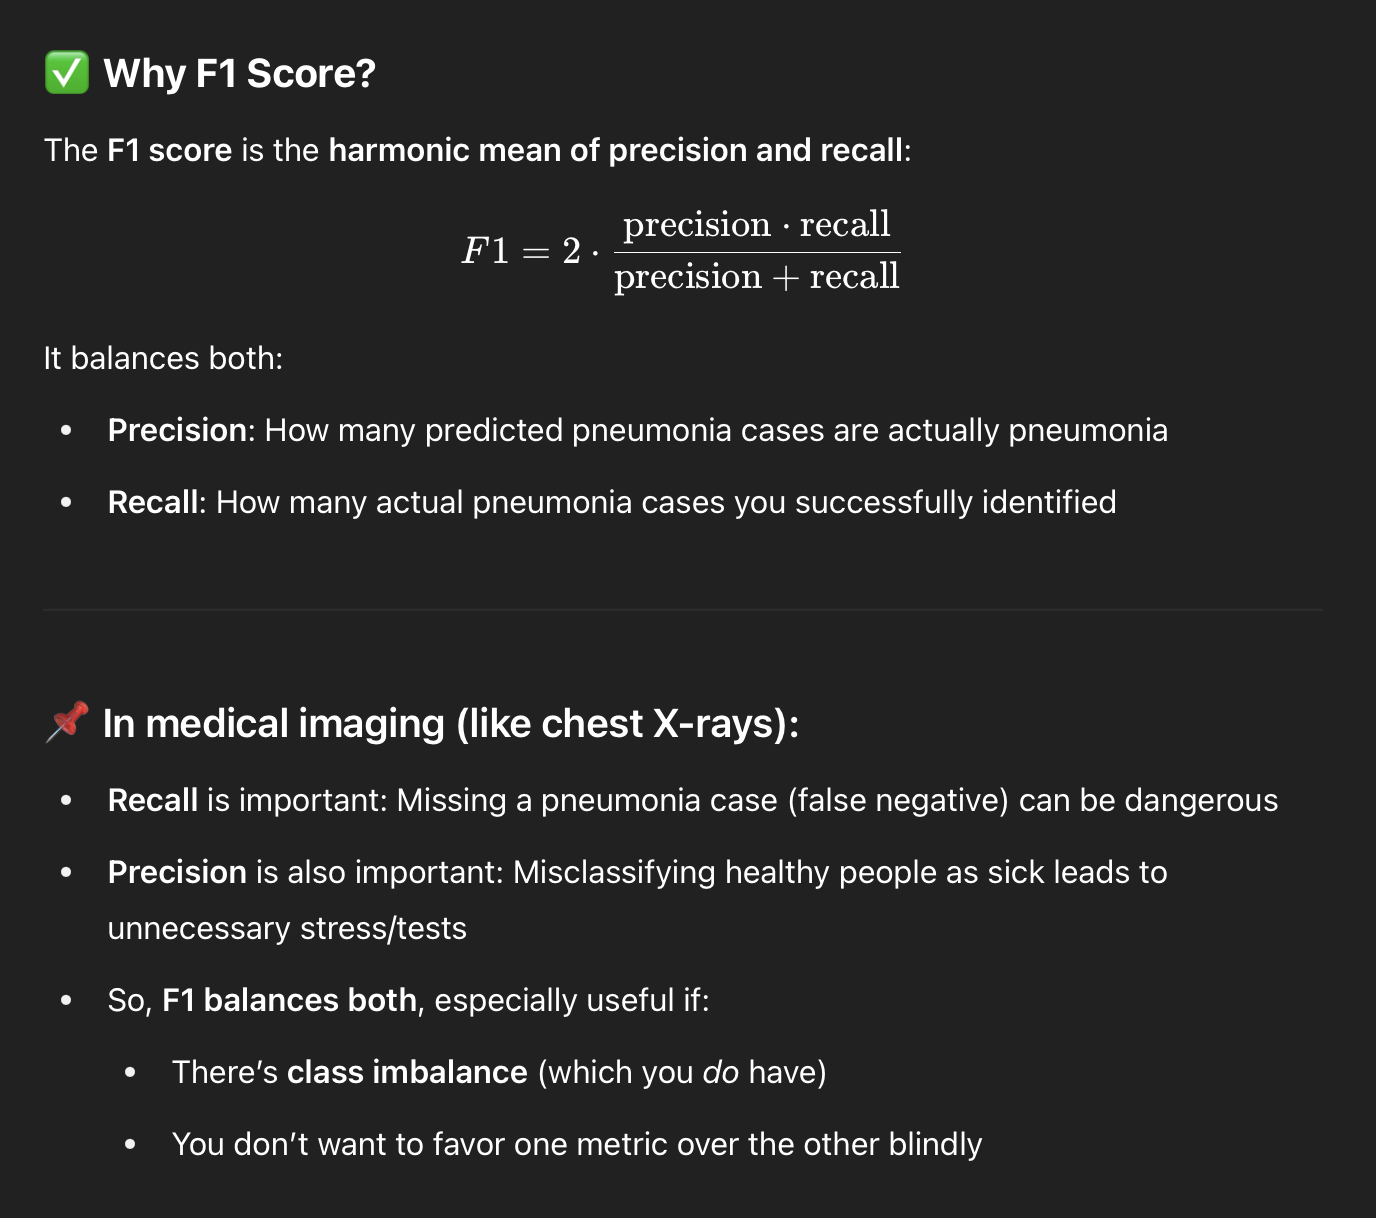

In [ ]:
# keras fine-tuning with bayesian optimization
tuner1 = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_auc',direction='max'),
    max_trials=8, 
    executions_per_trial=1,
    directory='kt_dir_bayes',
    project_name='pneumonia_bayes_tuning'
)

# searching for the optimal hyperparameters
tuner1.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

#best model
best_model1 = tuner1.get_best_models(num_models=1)[0]
best_hps1 = tuner1.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps1.values)

#fitting with the best model
history1 = best_model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
)

Trial 1 Complete [00h 04m 05s]
val_auc: 0.9782556891441345

Best val_auc So Far: 0.9782556891441345
Total elapsed time: 00h 04m 05s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
32                |64                |conv1_filters
32                |96                |conv2_filters
192               |128               |conv3_filters
256               |256               |dense_units
0.3               |0.4               |dropout_rate
3.3421e-05        |0.00019248        |learning_rate

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.5778 - auc: 0.7131 - loss: 0.6381 - val_accuracy: 0.8359 - val_auc: 0.9492 - val_loss: 0.4435
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.8204 - auc: 0.9109 - loss: 0.4035 - val_accuracy: 0.8803 - val_auc: 0.9601 - val_loss: 0.3090
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.8815 - auc: 0.9520 - loss: 0.2933 - val_accuracy: 0.7932 - val_auc: 0.9687 - val_lo

In [ ]:
#accuracy and loss plots over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

In [ ]:
#evaluation of the best model on the test set
test_loss1, test_accuracy1 = best_model1.evaluate(test_generator, verbose=1)

print(f"\n Test Accuracy: {test_accuracy1 * 100:.2f}%")
print(f" Test Loss: {test_loss1:.4f}")

**Παραδείγματα normal and pneumonia** 

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step


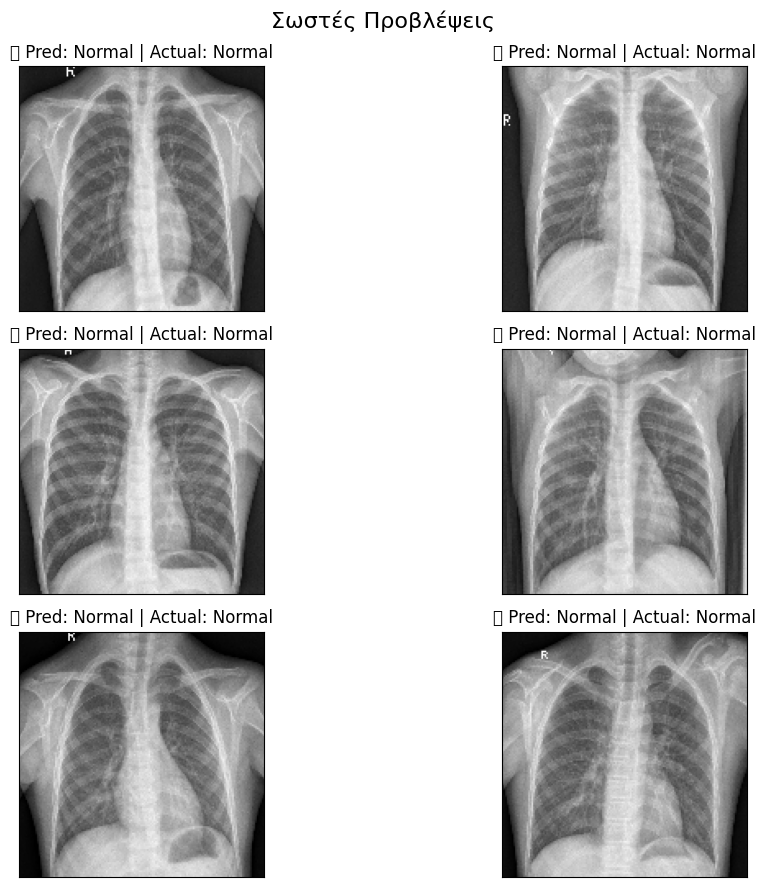

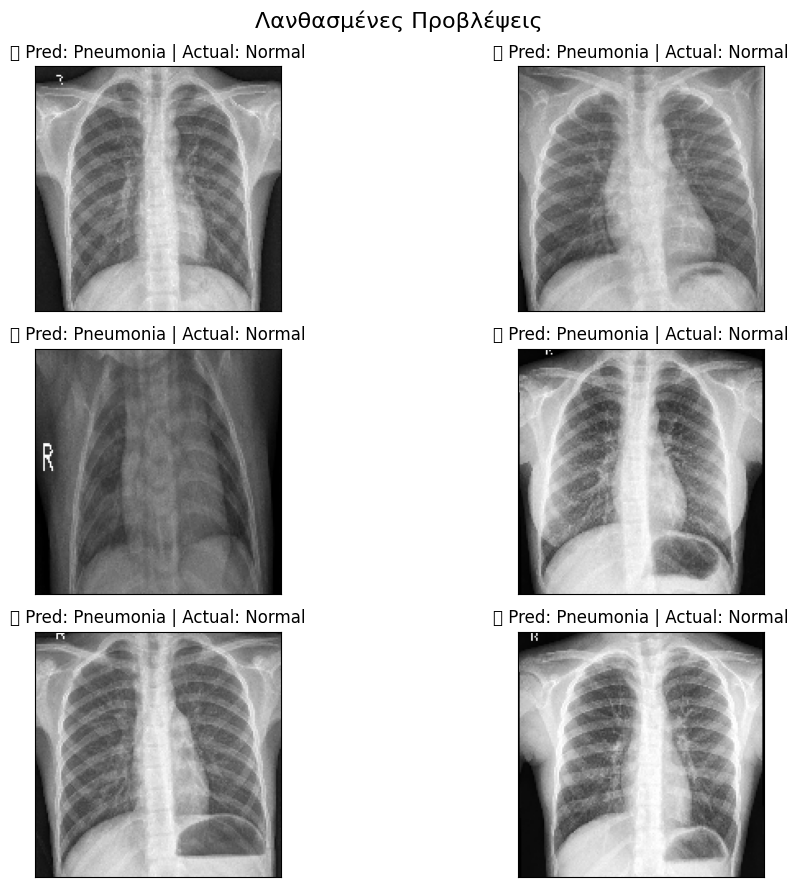

In [25]:
# Βήμα 1: Λήψη εικόνων και labels από τον test_generator
x_test, y_test = [], []

for i in range(len(test_generator)):
    x, y = test_generator[i]
    x_test.extend(x)
    y_test.extend(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Βήμα 2: Προβλέψεις
pred_probs = best_model.predict(x_test)
predictions = (pred_probs > 0.5).astype(int).reshape(-1)

# Βήμα 3: Ευρετήρια σωστών και λάθος
correct = np.where(predictions == y_test)[0]
incorrect = np.where(predictions != y_test)[0]

labels = {0: 'Normal', 1: 'Pneumonia'}

# Βήμα 4: Εμφάνιση 6 σωστών
plt.figure(figsize=(12, 9))
for i, c in enumerate(correct[:6]):
    plt.subplot(3, 2, i+1)
    plt.imshow(x_test[c])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Pred: {labels[predictions[c]]} | Actual: {labels[int(y_test[c])]}")
plt.suptitle("Σωστές Προβλέψεις", fontsize=16)
plt.tight_layout()
plt.show()

# Βήμα 5: Εμφάνιση 6 λανθασμένων
plt.figure(figsize=(12, 9))
for i, c in enumerate(incorrect[:6]):
    plt.subplot(3, 2, i+1)
    plt.imshow(x_test[c])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Pred: {labels[predictions[c]]} | Actual: {labels[int(y_test[c])]}")
plt.suptitle("Λανθασμένες Προβλέψεις", fontsize=16)
plt.tight_layout()
plt.show()